In [2]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE


import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

from utils import normalize, sparse_mx_to_torch_sparse_tensor, accuracy
from scipy.sparse import csr_matrix, coo_matrix, diags,eye

In [3]:
class graph_convolution_layer(Module):

    def __init__(self, in_features, out_features):
        super(graph_convolution_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.weight.data.uniform_(-1, 1)
        self.bias.data.uniform_(-1, 1)


    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output + self.bias

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = graph_convolution_layer(nfeat, nhid)
        self.gc2 = graph_convolution_layer(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.sigmoid(self.gc1(x, adj))
        embedding = x
        x = F.dropout(x, self.dropout, training=self.training)
       
        x = self.gc2(x, adj)
        return embedding, F.log_softmax(x, dim=1)


In [4]:

seed = 42
epochs = 500
lr = 0.01
weight_decay = 5e-4
hidden = 2
dropout = 0.5

np.random.seed(seed)
torch.manual_seed(seed)




In [6]:
"""Load karate club dataset"""
print('Loading karate club dataset...')

path="karate_club/"

edges = np.loadtxt("{}edges.txt".format(path), dtype=np.int32) - 1  # 0-based indexing
features = eye(np.max(edges+1), dtype=np.float32).tocsr()
idx_labels = np.loadtxt("{}mod-based-clusters.txt".format(path), dtype=np.int32)
idx_labels = idx_labels[idx_labels[:, 0].argsort()]

labels = idx_labels[:, 1]
classes = np.unique(labels)
one_hot_classes = dict(zip(classes, np.squeeze(np.eye(len(classes))[list(range(len(classes)))])))
one_hot_labels = np.array([one_hot_classes[i] for i in labels])

adj = coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)

# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

adj = normalize(adj + eye(adj.shape[0]))




print('Dataset has {} nodes, {} edges, {} features, {} classes'.format(adj.shape[0], edges.shape[0], features.shape[1],5))


idx_train = [0, 2, 4, 8]
idx_val = range(0, len(labels))
idx_test = range(0, len(labels))

features = torch.FloatTensor(np.array(features.todense()))
labels = torch.LongTensor(np.where(one_hot_labels)[1])
adj = sparse_mx_to_torch_sparse_tensor(adj)

idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)


Loading karate club dataset...
Dataset has 34 nodes, 78 edges, 34 features, 5 classes


In [7]:


# Model and optimizer
model = GCN(nfeat=features.shape[1], nhid=hidden, nclass=labels.max().item() + 1, dropout=dropout)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

print (model)

GCN(
  (gc1): graph_convolution_layer()
  (gc2): graph_convolution_layer()
)


c:\users\sandi\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


FileNotFoundError: [Errno 2] No such file or directory: 'figure/0.jpg'

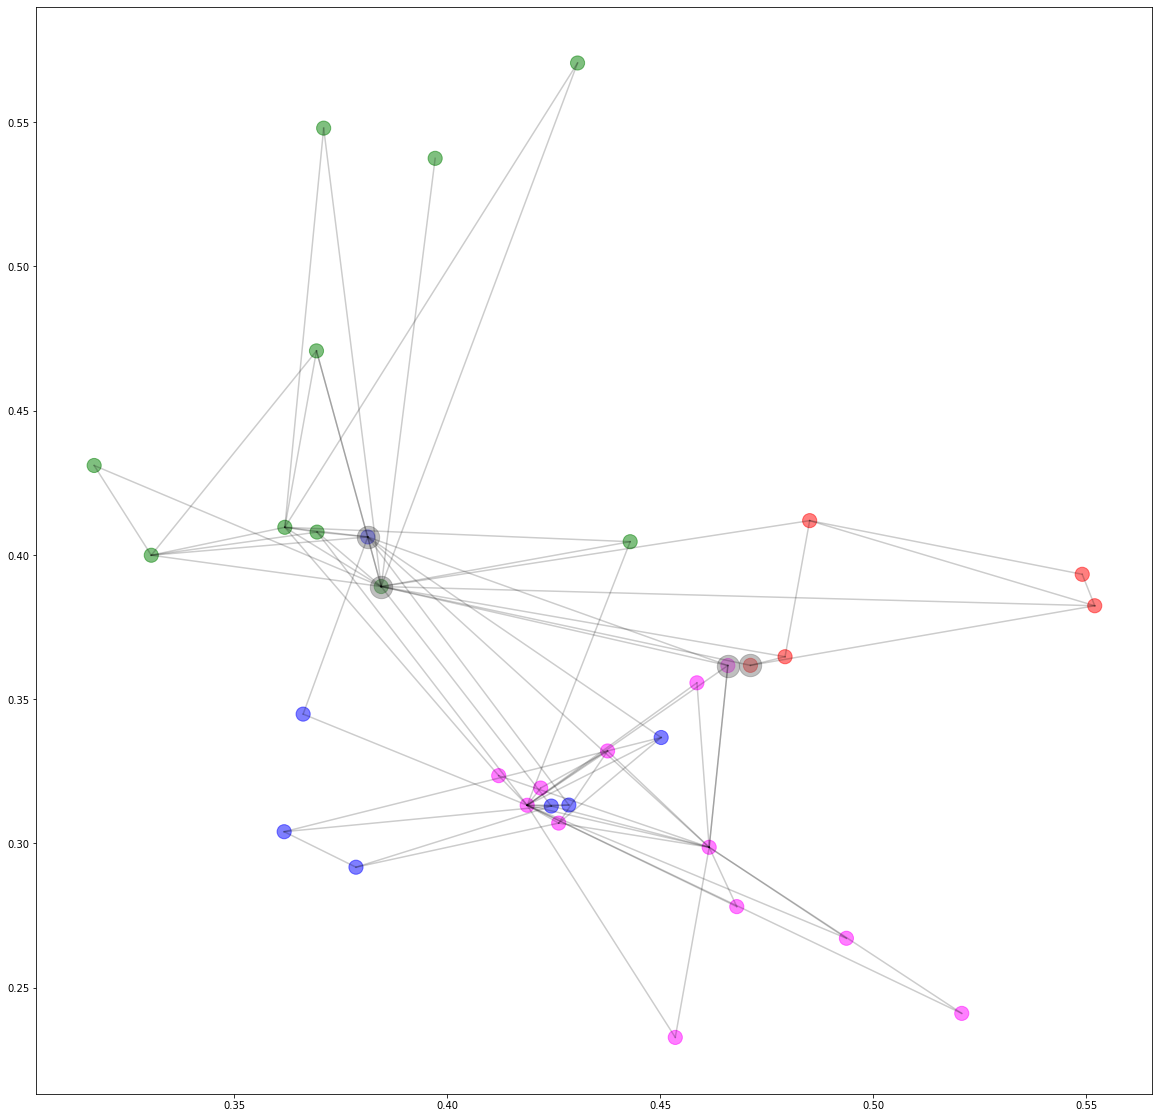

In [8]:
import math



def save_plot(embedding, edges, labels, epoch):
    X = np.array(embedding.detach().numpy())
    X_tsne = X
    
    labelled =  X_tsne[[0,2,4,8]]



    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    
    axes = plt.gca()


    color_map = {0:'red', 1:'green', 2:'blue', 3:'magenta', 4:'black', 5:'orange', 6:'pink'}
    colors = [color_map[i] for i in labels.numpy()]

    def connectpoints(x,y,p1,p2):
        x1, x2 = x[p1], x[p2]
        y1, y2 = y[p1], y[p2]
        plt.plot([x1,x2],[y1,y2],'k-',alpha=0.2)

    for edge in edges:
        connectpoints(X_tsne.T[0], X_tsne.T[1], edge[0], edge[1])



    plt.scatter(X_tsne.T[0], X_tsne.T[1], c = colors, alpha=0.5, s=200)
    plt.scatter(labelled.T[0], labelled.T[1], c = 'grey', alpha=0.5, s=500)
    plt.savefig('figure/' + str(epoch) + '.jpg')
    plt.clf()



def test():
    model.eval()
    embedding, output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))



t_total = time.time()
for epoch in range(epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    embedding, output = model(features, adj)
    
    save_plot(embedding, edges, labels, epoch)
    
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()


    model.eval()
    embedding, output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()
